In [1]:
import torch
import torchvision
import Dataset as D
import transform as T
from torch.utils.data import DataLoader
from validation import validation
from plot import show_hist

In [2]:
lr = 5e-5
batch_size = 128

In [3]:
# dataset
img_labels = D.ImageLabels('/mnt/training_labels.txt')
dataset, val_dataset = D.get_train_val_dataset('/mnt/training_images', img_labels=img_labels,
                                               transform=T.get_transform(), val=0.3)
class_transformer = D.ClassTransform('/mnt/classes.txt')
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=32)

In [4]:
device = torch.device('cuda:0')

In [5]:
# model
model = torch.nn.Sequential(
    torchvision.models.resnet50(pretrained=True),
    torch.nn.Linear(1000, class_transformer.total_size),
)
model = torch.nn.DataParallel(model)
model.to(device)

DataParallel(
  (module): Sequential(
    (0): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace

In [6]:
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-6)

In [7]:
# loss
loss_function = torch.nn.CrossEntropyLoss()

In [8]:
# training history
train_loss, validation_loss = [], []
train_acc, validation_acc = [], []

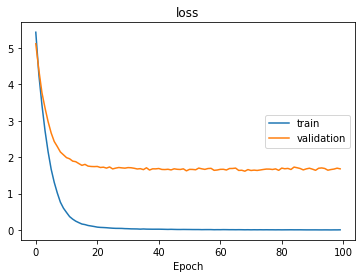

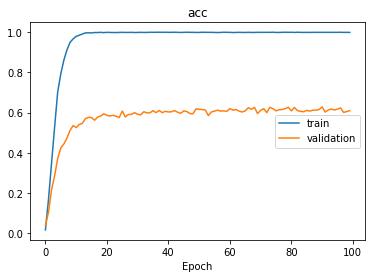

In [9]:
from IPython.display import clear_output

# training loop
epoch = 100
for i in range(epoch):
    # train
    model.train()
    loss_sum, positive, cnt = 0., 0, 0
    for labels, images in data_loader:
        y_true = torch.tensor(class_transformer.to_order(labels)).to(device)
        y_pred = model(images.to(device))

        loss = loss_function(y_pred, y_true)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # metrics
        cnt += 1
        loss_sum += loss.item()
        pre_class = class_transformer.to_class_name(y_pred)
        for ind, pre_label in enumerate(pre_class):
            if pre_label == labels[ind]:
                positive += 1

    # validation
    model.eval()
    metrics = validation(model, val_dataset, class_transformer, loss_function, device)

    # record the loss
    train_loss.append(loss_sum/cnt)
    validation_loss.append(metrics['loss'])

    # record the acc
    train_acc.append(positive / len(dataset))
    validation_acc.append(metrics['acc'])

    print('epoch', i, 'finish')
    print(metrics)

    
    clear_output()
    show_hist([train_loss, validation_loss], 'loss', ['train', 'validation'])
    show_hist([train_acc, validation_acc], 'acc', ['train', 'validation'])

In [10]:
torch.save(model.state_dict(), '/mnt/baseline')

In [11]:
torch.cuda.empty_cache()